# Squidpy analysis of Vizgen data

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
import os
from matplotlib import pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
import geopandas as gpd

/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.se

## 2. Setup

In [2]:
os.chdir("/beegfs/scratch/ric.sessa/kubacki.michal/SRF_Linda/SRF_Spatial_segmentation")

## 3. Load Data

In [3]:
data_dir = "./DATA/p0-p7/R1"
# Create a directory to save the results
results_dir = os.path.join(data_dir, "analysis_results")
os.makedirs(results_dir, exist_ok=True)

In [4]:
adata = sq.read.vizgen(
    path=data_dir,
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
)
print("Data loaded:")
print(adata)

Data loaded:
AnnData object with n_obs × n_vars = 45583 × 960
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'TAG_raw', 'TAG_high_pass', 'Snap25_raw', 'Snap25_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'Ttr_raw', 'Ttr_high_pass', 'Pcp4_raw', 'Pcp4_high_pass', 'Anti-SETBP1_raw', 'Anti-SETBP1_high_pass', 'hSETBP1_raw', 'hSETBP1_high_pass', 'PolyT_raw', 'PolyT_high_pass'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'


### Get Library ID

In [5]:
# Get the library id from the anndata object
try:
    library_id = list(adata.uns['spatial'].keys())[0]
    print(f"Using library_id: {library_id}")
except (KeyError, IndexError):
    print("Could not automatically determine library_id. Spatial plots may fail.")
    library_id = None

Using library_id: library


### Load Cell Boundaries

In [6]:
# Load the cell boundaries and add them to the anndata object
try:
    segmentation_path = os.path.join(data_dir, "cell_boundaries.parquet")
    boundaries = gpd.read_parquet(segmentation_path)
    adata.uns['spatial'][library_id]['segmentations'] = boundaries
    print("Successfully loaded cell boundaries.")
except Exception as e:
    print(f"Could not load cell boundaries: {e}")

Successfully loaded cell boundaries.


## 4. Pre-processing and QC

We perform standard pre-processing and quality control steps.

Saved QC metrics distribution plot.


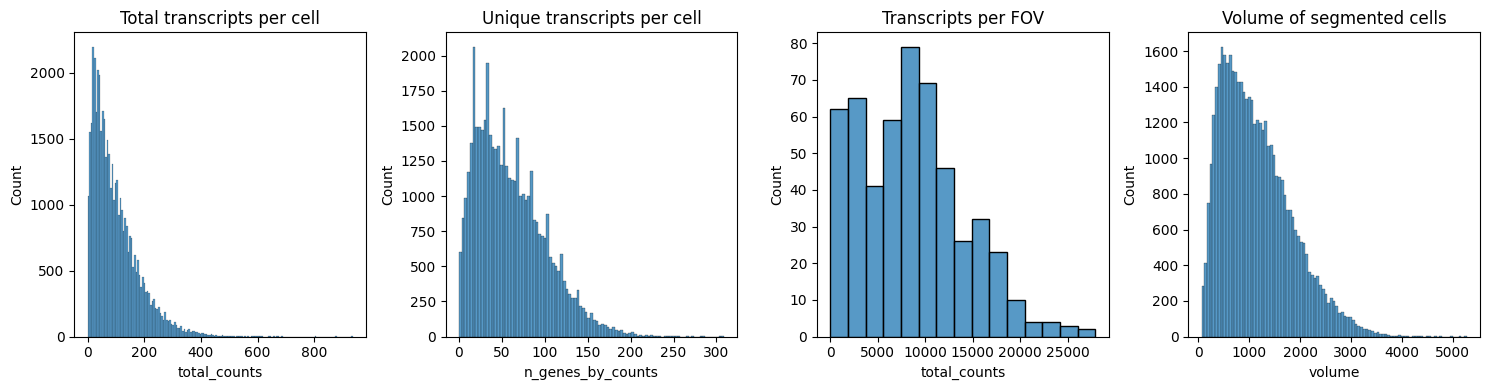

In [7]:
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, percent_top=(50, 100, 200, 300), inplace=True)

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
axs[0].set_title("Total transcripts per cell")
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, ax=axs[1])
axs[1].set_title("Unique transcripts per cell")
sns.histplot(adata.obs.groupby("fov").sum()["total_counts"], kde=False, ax=axs[2])
axs[2].set_title("Transcripts per FOV")
sns.histplot(adata.obs["volume"], kde=False, ax=axs[3])
axs[3].set_title("Volume of segmented cells")
fig.tight_layout()
plt.savefig(os.path.join(results_dir, "qc_metrics_distribution.png"))
print("Saved QC metrics distribution plot.")

### Filtering

In [8]:
# Filter cells with low expression and genes that are expressed in too few cells.
print(f"Number of cells before filtering: {adata.n_obs}")
sc.pp.filter_cells(adata, min_counts=50)
print(f"Number of cells after filtering by counts: {adata.n_obs}")

print(f"Number of genes before filtering: {adata.n_vars}")
sc.pp.filter_genes(adata, min_cells=10)
print(f"Number of genes after filtering by cells: {adata.n_vars}")

Number of cells before filtering: 45583
Number of cells after filtering by counts: 30084
Number of genes before filtering: 960
Number of genes after filtering by cells: 960


### Normalization and Scaling

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
print("Normalization and scaling complete.")

Normalization and scaling complete.


## 5. Dimensionality Reduction and Clustering

In [10]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1.0)
print("Dimensionality reduction and clustering complete.")

/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dimensionality reduction and clustering complete.


## 6. Visualization

### UMAP

In [11]:
sc.pl.umap(adata, color=["leiden"], size=10, show=False, save="_leiden.png")
# Move the file to the results directory
Path("figures/umap_leiden.png").rename(f"{results_dir}/umap_leiden.png")
shutil.rmtree("figures")
print("Saved UMAP plot.")

/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Saved UMAP plot.


### Spatial Scatter

Saved spatial scatter plot.


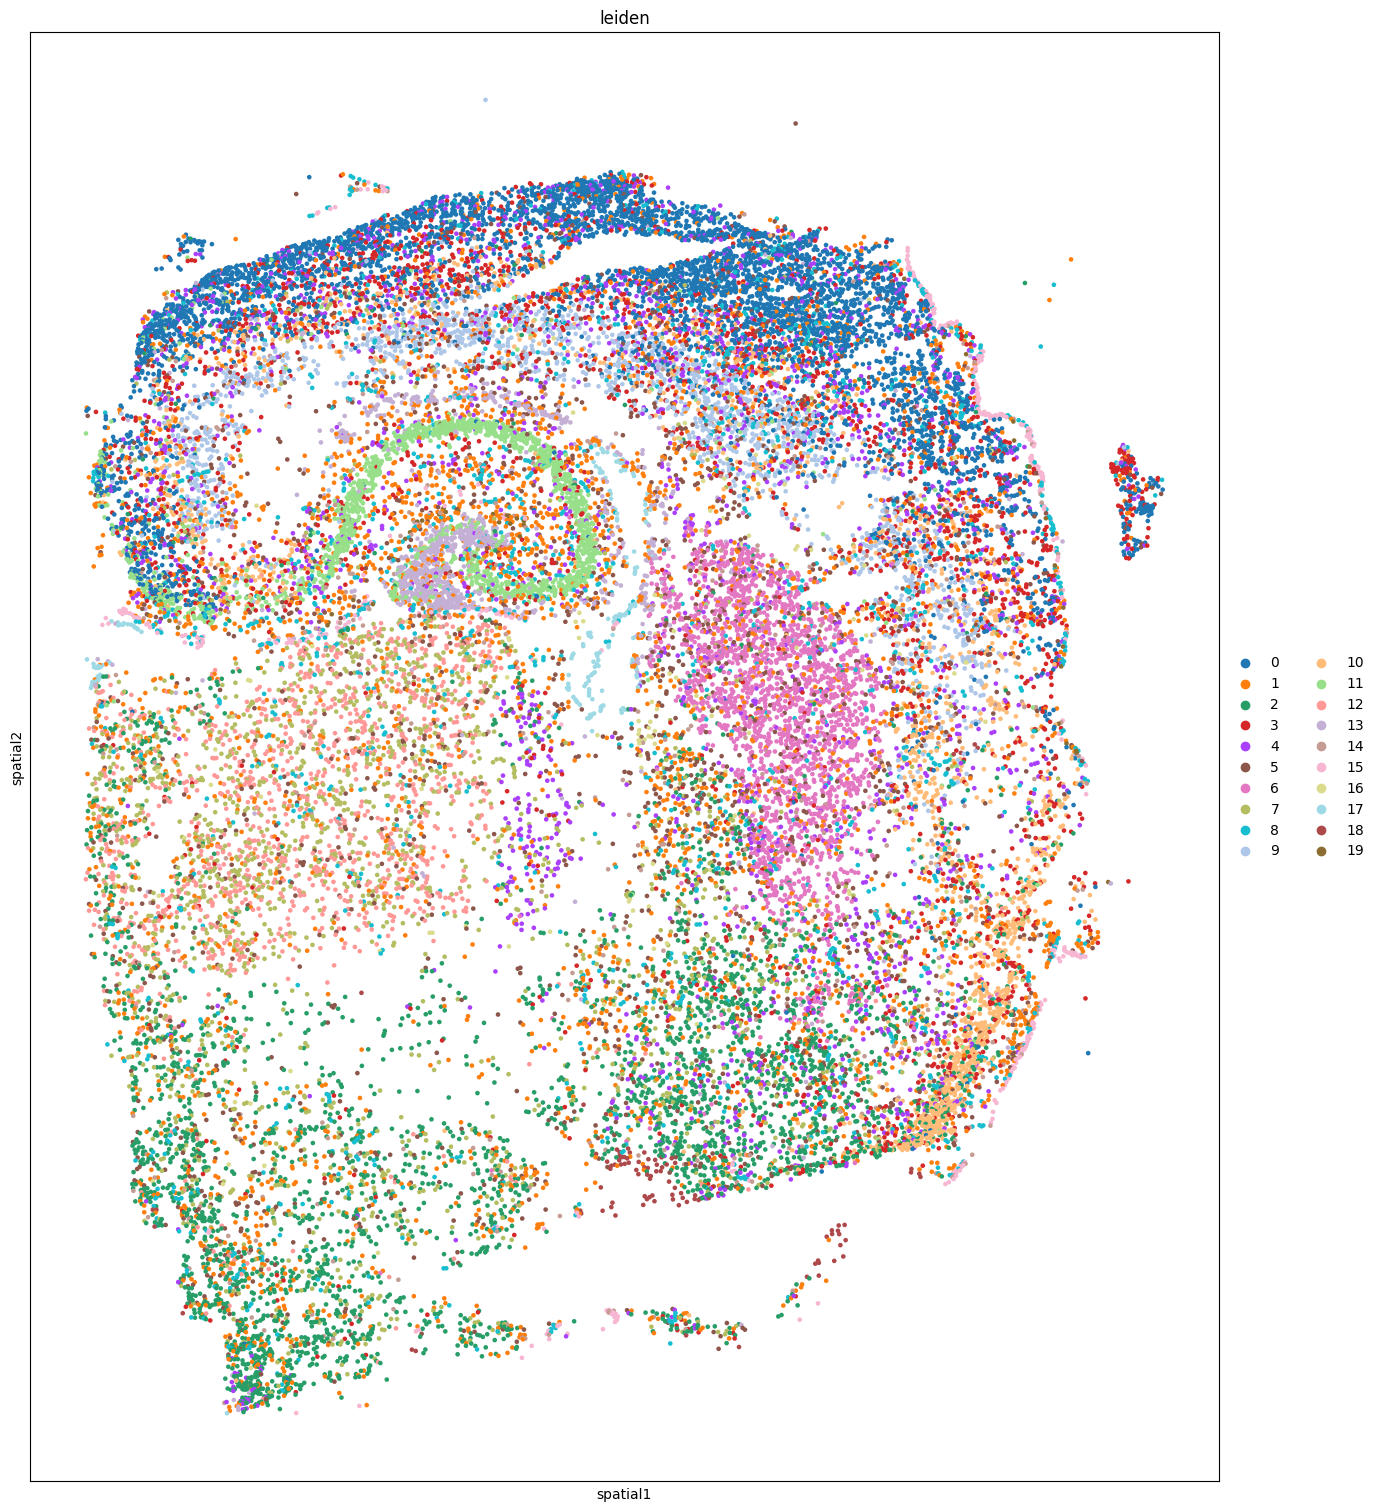

In [12]:
sq.pl.spatial_scatter(
    adata,
    library_id=library_id,
    color="leiden",
    img=False,
    figsize=(15, 15),
    size=10,
    save="spatial_leiden.png"
)
# Move the file to the results directory
if os.path.exists("figures/spatial_leiden.png"):
    Path("figures/spatial_leiden.png").rename(f"{results_dir}/spatial_leiden.png")
    shutil.rmtree("figures")
    print("Saved spatial scatter plot.")
else:
    print("Could not save spatial scatter plot.")

## 7. Spatial Analysis
Spatial organization of the clustered cells.

### Neighborhood Enrichment
Clusters that are spatially co-enriched.

100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 550.11/s]


Saved neighborhood enrichment plot.


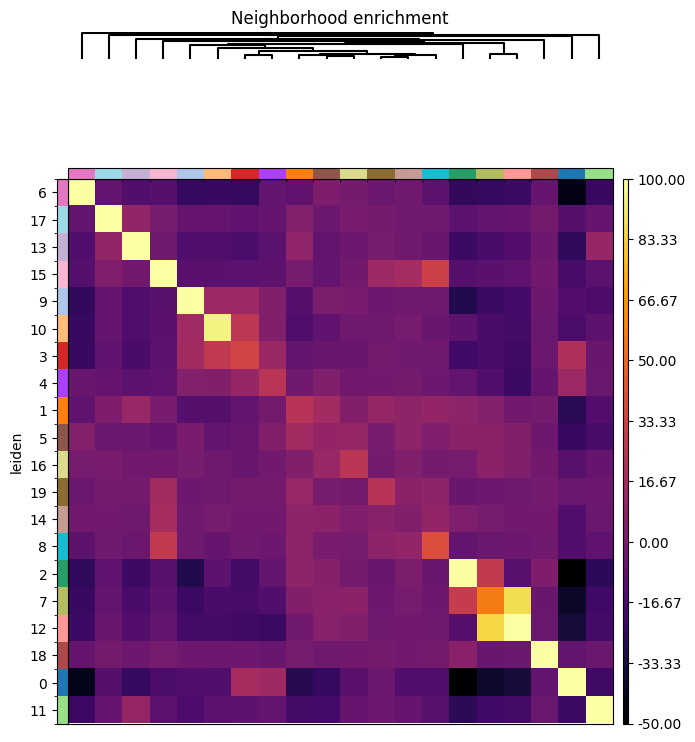

In [13]:
sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial")
sq.gr.nhood_enrichment(adata, cluster_key="leiden")
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    method="average",
    cmap="inferno",
    vmin=-50,
    vmax=100,
    figsize=(7, 7),
    save="_enrichment.png",
)
Path("figures/_enrichment.png").rename(f"{results_dir}/neighborhood_enrichment.png")
shutil.rmtree("figures")
print("Saved neighborhood enrichment plot.")

### Spatial Autocorrelation (Moran's I)
Identify genes that show a non-random spatial distribution.

In [14]:
sq.gr.spatial_autocorr(adata, mode="moran")
print("Top 10 spatially autocorrelated genes:")
print(adata.uns["moranI"].head(10))

Top 10 spatially autocorrelated genes:
                I  pval_norm  var_norm  pval_norm_fdr_bh
Tcf7l2   0.638182        0.0   0.00001               0.0
Satb2    0.443939        0.0   0.00001               0.0
Gfap     0.435314        0.0   0.00001               0.0
Gng7     0.375814        0.0   0.00001               0.0
Zbtb20   0.350461        0.0   0.00001               0.0
Ubc      0.314793        0.0   0.00001               0.0
Nfib     0.299965        0.0   0.00001               0.0
Cldn2    0.297226        0.0   0.00001               0.0
Cux2     0.289801        0.0   0.00001               0.0
Sparcl1  0.287824        0.0   0.00001               0.0


### Visualize top spatially autocorrelated genes

Saved top spatially autocorrelated genes plot.

Analysis complete. Results are in the 'analysis_results' directory.


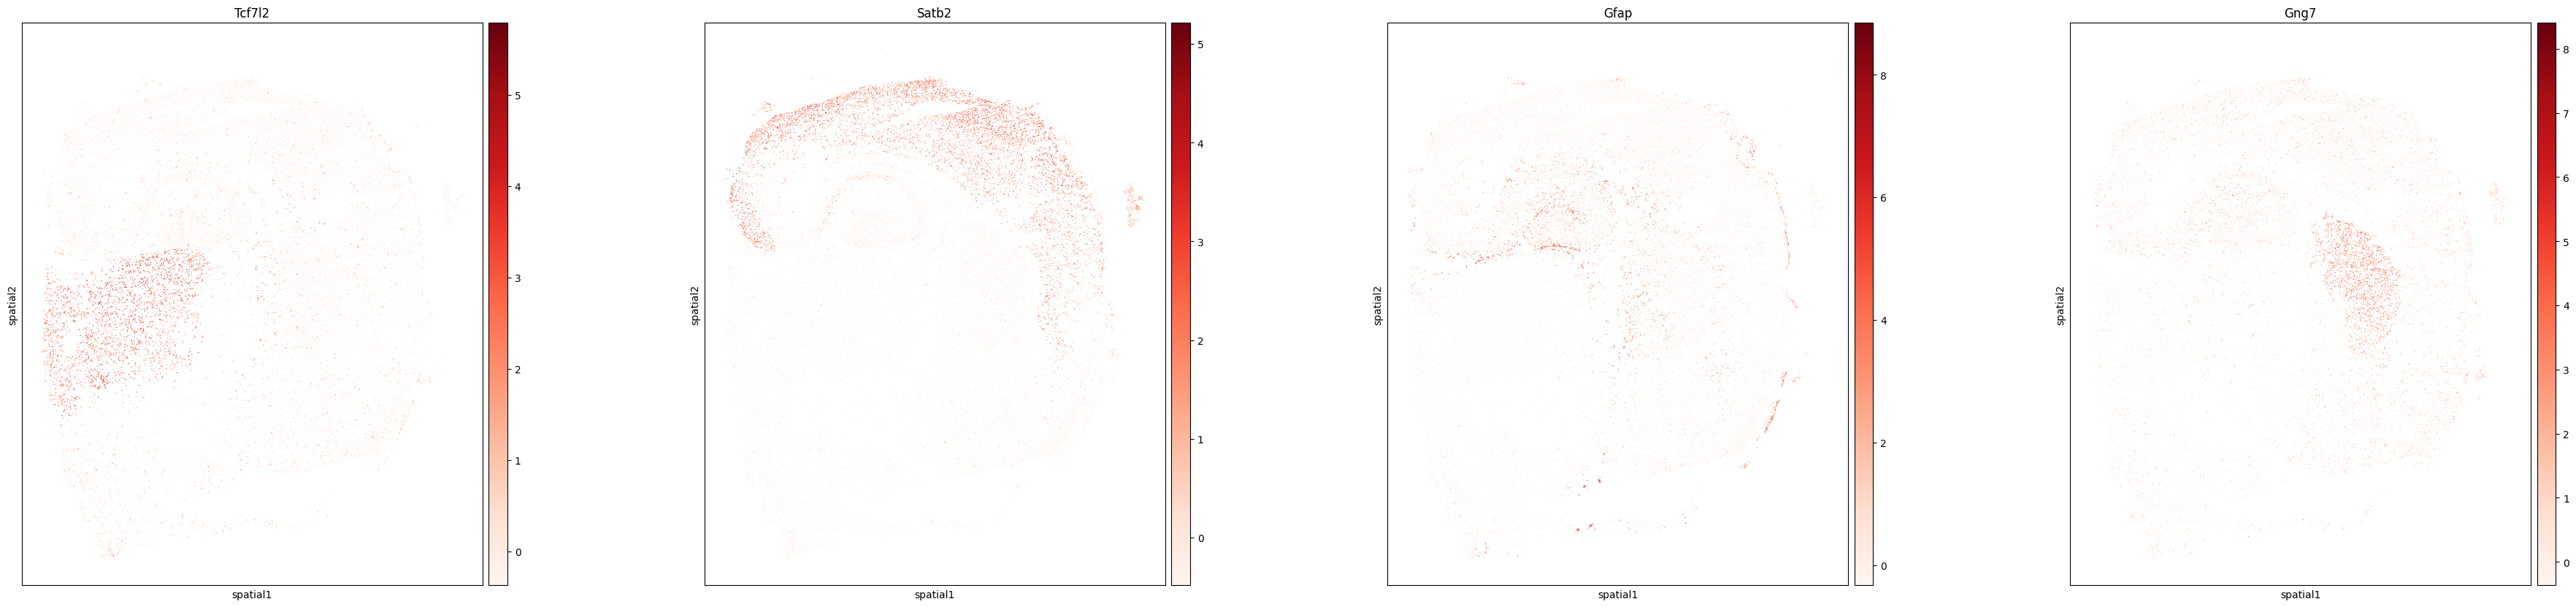

In [15]:
top_autocorr = adata.uns["moranI"]["I"].sort_values(ascending=False).head(4).index.tolist()
sq.pl.spatial_scatter(
    adata,
    library_id=library_id,
    color=top_autocorr,
    size=5,
    cmap="Reds",
    img=False,
    figsize=(10, 10),
    save="spatial_top_autocorr.png"
)
Path("./figures/spatial_top_autocorr.png").rename(f"{results_dir}/spatial_top_autocorr.png")
os.rmdir("figures")
print("Saved top spatially autocorrelated genes plot.")

print("\nAnalysis complete. Results are in the 'analysis_results' directory.")

In [16]:
# Save the AnnData object, but first remove GeoDataFrame from spatial metadata
# as it cannot be serialized to HDF5 format
print("Preparing to save AnnData object...")

# Store the boundaries separately if they exist
boundaries_to_save = None
if library_id and 'segmentations' in adata.uns['spatial'][library_id]:
    boundaries_to_save = adata.uns['spatial'][library_id]['segmentations']
    # Remove the GeoDataFrame from spatial metadata before saving
    del adata.uns['spatial'][library_id]['segmentations']
    print("Removed GeoDataFrame from spatial metadata for HDF5 compatibility.")

# Save the AnnData object
adata.write(os.path.join(results_dir, "squidpy_adata_1.h5ad"))
print("Successfully saved AnnData object.")

# Save the boundaries separately as parquet file
if boundaries_to_save is not None:
    boundaries_path = os.path.join(results_dir, "cell_boundaries.parquet")
    boundaries_to_save.to_parquet(boundaries_path)
    print(f"Saved cell boundaries separately to: {boundaries_path}")
    
    # Restore the boundaries to the AnnData object for continued use in this session
    adata.uns['spatial'][library_id]['segmentations'] = boundaries_to_save
    print("Restored boundaries to AnnData object for current session.")

Preparing to save AnnData object...
Removed GeoDataFrame from spatial metadata for HDF5 compatibility.
Successfully saved AnnData object.
Saved cell boundaries separately to: ./DATA/p0-p7/R1/analysis_results/cell_boundaries.parquet
Restored boundaries to AnnData object for current session.
